In [1]:
import torch
torch.cuda.set_device('cuda:0')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# pip install torch-summary

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch

# import torchsummary
import torchvision as tv
from torchvision import transforms, datasets
from torchvision.transforms import v2

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from torch.distributions.normal import Normal
import torch.nn.functional as F

import torch.nn as nn
from torch.nn import ReLU
from torch.optim.lr_scheduler import _LRScheduler


In [4]:
import pandas as pd


data = pd.read_csv("./data/list_attr_celeba.csv")
print(data.columns)

# Replace all -1 values with 0
data.replace(-1, 0, inplace=True)
data

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                 0                1           1   
1       000002.jpg                 0                0           0   
2       000003.jpg                 0                0           0   
3       000004.jpg                 0                0           1   
4       000005.jpg                 0                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                 0                0           1   
202595  202596.jpg                 0                0           0   
202596  202597.jpg                 0                0           0   
202597  202598.jpg                 0                1           1   
202598  202599.jpg                 0                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                     0     0      0         0         0           0  ...   
1                     1     0      0         0         1           0  ...   
2                     0     0      0         1         0           0  ...   
3                     0     0      0         0         0           0  ...   
4                     0     0      0         1         0           0  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594                0     0      0         1         0           0  ...   
202595                0     0      1         1         0           0  ...   
202596                0     0      0         0         0           1  ...   
202597                0     0      0         1         0           1  ...   
202598                0     0      0         0         0           0  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0               0        1              1          0                 1   
1               0        1              0          0                 0   
2               0        0              0          1                 0   
3               0        0              1          0                 1   
4               0        0              0          0                 0   
...           ...      ...            ...        ...               ...   
202594          0        0              0          0                 0   
202595          0        1              1          0                 0   
202596          0        1              0          0                 0   
202597          0        1              0          1                 1   
202598          0        0              0          1                 0   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                 0                 1                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 1                 1                0   
4                 0                 1                 0                0   
...             ...               ...               ...              ...   
202594            0                 1                 0                0   
202595            0                 0                 0                0   
202596            0                 0                 0                0   
202597            0                 1                 0                0   
202598            0                 1                 0                0   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

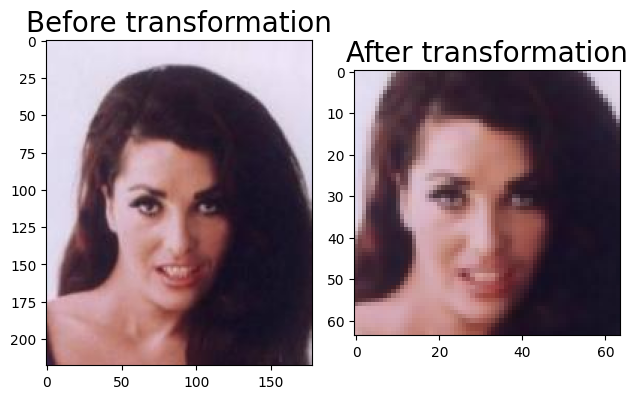

<Figure size 640x480 with 0 Axes>

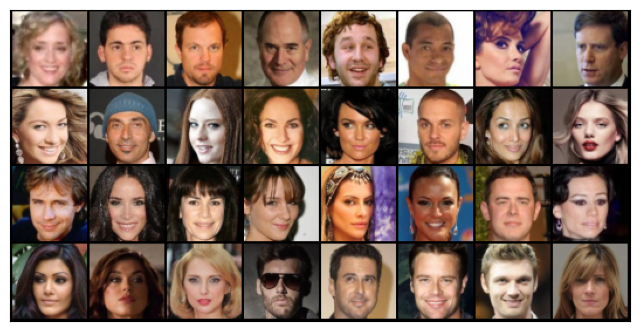

In [5]:


def create_filepaths():
    filenames = pd.read_csv('./data/list_eval_partition.csv')

    train_filenames = filenames[filenames['partition'] == 0]['image_id'].values
    val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = './data/img_align_celeba/img_align_celeba/'
    train_filepaths = path_to_files + train_filenames
    val_filepaths = path_to_files+val_filenames
    
    return train_filepaths, val_filepaths

def create_filepaths_all(data):
    # filenames = pd.read_csv('./data/list_eval_partition.csv')

    imagename = data['image_id'].values
    # val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = './data/img_align_celeba/img_align_celeba/'
    # train_filepaths = path_to_files + train_filenames
    # val_filepaths = path_to_files+val_filenames
    
    filepaths = path_to_files + imagename
    
    return filepaths




# train_filepaths, val_filepaths = create_filepaths()
attrib = data
# attrib = data[data['Bald']==1]

all_paths = create_filepaths_all(attrib)


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break



INPUT_SHAPE=(3,64,64)

class CreateDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = [img for img in imgs if self.is_valid(img)]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = self.imgs[index]
        X = self.transform(image)
        return X, X
        
    def transform(self, path):
        img = tv.io.read_image(path)
        img = transforms.v2.functional.resized_crop(img, 40, 15, 148, 148, INPUT_SHAPE[1:], transforms.InterpolationMode.BILINEAR, True)/255.
        return img
    
    def is_valid(self, path):
        img = tv.io.read_image(path)
        return (img.shape[1] >= INPUT_SHAPE[1]) and (img.shape[2] >= INPUT_SHAPE[2])





# train_dataset = CreateDataset(train_filepaths)
# val_dataset = CreateDataset(val_filepaths)
dataset = CreateDataset(all_paths)

# train_dl = DataLoader(train_dataset, 32, shuffle=True, pin_memory=True, num_workers=2) #num_workers=3
# val_dl = DataLoader(val_dataset, 32, shuffle=True, pin_memory=True, num_workers=2)
dataloader = DataLoader(dataset, 32, shuffle=True, pin_memory=True, num_workers=2)

# plt.figure(figsize=(40, 40))
fig,axes = plt.subplots(1,2)
axes[0].imshow(tv.io.read_image(all_paths[10]).permute(1, 2, 0))
axes[0].set_title('Before transformation',fontsize=20)
axes[1].imshow(dataset.transform(all_paths[10]).permute(1,2,0))

axes[1].set_title('After transformation',fontsize=20)
plt.tight_layout()
plt.show()


plt.figure()
show_batch(dataloader, 32)
# plt.savefig("./images/batch.jpg", bbox_inches='tight')
plt.show()
plt.close()


In [6]:

class CelebAEncoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAEncoder, self).__init__()
        # Four 2D convolutional layers.
        self.conv1 = nn.Conv2d(3, 2048, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(2048, 1024, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(1024, 512, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(512, 256, kernel_size=5, stride=2, padding=2)
        # For a 64×64 input, after 4 conv layers the feature map becomes 4×4.
        self.fc = nn.Linear(256 * 4 * 4, 2048)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 2048, 32, 32]
        x = F.relu(self.conv2(x))   # [B, 1024, 16, 16]
        x = F.relu(self.conv3(x))   # [B, 512, 8, 8]
        x = F.relu(self.conv4(x))   # [B, 256, 4, 4]
        x = x.view(x.size(0), -1)     # Flatten
        x = self.fc(x)              # [B, 2048]
        # Split into two halves: one for μ and one for log-σ (pre-softplus)
        mu, log_sigma = torch.chunk(x, 2, dim=1)
        # Ensure σ > 0 using softplus.
        sigma = F.softplus(log_sigma)
        return mu, sigma

class CelebADecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebADecoder, self).__init__()
        # Transform the latent vector into a seed feature map.
        self.fc = nn.Linear(latent_dim, 2048 * 4 * 4)
        # Four transposed convolutional layers.
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(256, 3, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 2048, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # Use sigmoid to map the output to [0, 1].
        x = torch.sigmoid(self.deconv4(x))
        return x

class CelebAVAE(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAVAE, self).__init__()
        self.encoder = CelebAEncoder(latent_dim)
        self.decoder = CelebADecoder(latent_dim)
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        recon = self.decoder(z)
        return recon, mu, sigma

#########################################
# Loss Function for the VAE
#########################################

def loss_function(recon_x, x, mu, sigma):
    # Reconstruction loss (BCE) summed over all pixels.
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between the approximate posterior and the unit Gaussian.
    KL = -0.5 * torch.sum(1 + 2 * torch.log(sigma) - mu.pow(2) - sigma.pow(2))
    return BCE + KL

In [ ]:
 
class ActorNetwork(nn.Module):
    def __init__(self, z_dim, attr_dim=None):
        """
        If attr_dim is provided, the network is conditioned on attribute labels.
        """
        super(ActorNetwork, self).__init__()
        self.z_dim = z_dim
        self.use_attr = attr_dim is not None
        input_dim = z_dim
        if self.use_attr:
            # Map attribute labels to a 2048-dimensional embedding.
            self.attr_fc = nn.Linear(attr_dim, 2048)
            input_dim += 2048

        # Four fully connected layers with 2048 outputs each.
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        # Final layer produces 2*z_dim outputs (to split into δz and gate logits)
        self.fc_out = nn.Linear(2048, 2 * z_dim)
    
    def forward(self, z, y=None):
        """
        Args:
            z: latent vector [batch, z_dim]
            y: attribute labels [batch, attr_dim] (optional)
        Returns:
            Transformed z'
        """
        # Keep a copy of the original z for the residual update.
        z_orig = z
        if self.use_attr and y is not None:
            y_emb = F.relu(self.attr_fc(y))
            x = torch.cat([z, y_emb], dim=1)
        else:
            x = z
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc_out(x)
        delta_z, gate_logits = torch.chunk(x, 2, dim=1)
        gates = torch.sigmoid(gate_logits)
        # Compute the updated latent vector:
        z_transformed = (1 - gates) * z_orig + gates * delta_z
        return z_transformed


class CriticNetwork(nn.Module):
    def __init__(self, z_dim, attr_dim=None):
        """
        If attr_dim is provided, the critic is conditioned on attribute labels.
        """
        super(CriticNetwork, self).__init__()
        self.z_dim = z_dim
        self.use_attr = attr_dim is not None
        input_dim = z_dim
        if self.use_attr:
            self.attr_fc = nn.Linear(attr_dim, 2048)
            input_dim += 2048

        # Four fully connected layers with 2048 outputs each.
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        # Final layer produces a single output.
        self.fc_out = nn.Linear(2048, 1)
    
    def forward(self, z, y=None):
        """
        Args:
            z: latent vector [batch, z_dim]
            y: attribute labels [batch, attr_dim] (optional)
        Returns:
            Critic score in [0, 1]
        """
        if self.use_attr and y is not None:
            y_emb = F.relu(self.attr_fc(y))
            x = torch.cat([z, y_emb], dim=1)
        else:
            x = z
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc_out(x)
        output = torch.sigmoid(x)
        return output



In [7]:
import os
import torch
import pandas as pd
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

device = 'cuda:0'
base_path = './data/img_align_celeba/img_align_celeba'

# Read CSV and preprocess
data = pd.read_csv("./data/list_attr_celeba.csv")
columns_to_keep = [
    'image_id', 'Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Bald', 
    'Eyeglasses', 'No_Beard', 'Wearing_Hat', 'Smiling', 'Male', 'Young'
]
data = data.replace(-1, 0)
data = data[columns_to_keep]

# Load VAE Modela
vaeModel = CelebAVAE()
vaeModel.load_state_dict(torch.load('celeba_vae.pth', map_location=device))
vaeModel.to(device).eval()
encoder = vaeModel.encoder

# Image transformations
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.float() / 255.0),  # Normalize [0,1]
])

# Custom Dataset that returns latent vectors
class CelebADataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None, encoder=None, device='cpu', samples_per_image=100):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.encoder = encoder
        self.device = device
        self.samples_per_image = samples_per_image
        self.sigma = torch.zeros(1,1024).to(device)
        self.size = 0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']
        image_path = os.path.join(self.base_path, image_id)

        # Load Image
        try:
            img = read_image(image_path)
            if img.shape[1] < 64 or img.shape[2] < 64:
                # You might want to handle this case (e.g., skip or resize differently)
                return None
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return None

        # Crop & Resize
        img = transforms.functional.resized_crop(
            img, top=40, left=15, height=148, width=148, size=(64, 64), 
            interpolation=transforms.InterpolationMode.BILINEAR, antialias=True
        )
        
        # Apply transformation (e.g., normalization)
        if self.transform:
            img = self.transform(img)

        # Extract attributes (excluding 'image_id')
        attributes = torch.tensor(row[columns_to_keep[1:]].values.astype(float), dtype=torch.float32).to(device)

        # Move image to the proper device and add batch dimension
        img = img.to(self.device)
        img = img.unsqueeze(0)  # Shape: [1, C, H, W]

        with torch.no_grad():
            # Compute latent parameters for the image
            mu, sigma = self.encoder(img)  # Expected shape: [1, latent_dim]
            self.sigma += sigma
            # Generate random noise and sample latent vectors
            eps = torch.randn((self.samples_per_image, *mu.shape), device=self.device)  # Shape: [samples, 1, latent_dim]
            z_samples = mu.unsqueeze(0) + sigma.unsqueeze(0) * eps  # Shape: [samples, 1, latent_dim]
            z_samples = z_samples.squeeze(1)  # Now: [samples, latent_dim]
            # Expand attributes to match the number of samples and concatenate
            attrs_expanded = attributes.unsqueeze(0).expand(self.samples_per_image, -1)  # [samples, attribute_dim]
            final_vectors = torch.cat((z_samples, attrs_expanded), dim=1)  # [samples, latent_dim + attribute_dim]
        self.size+=1

        return final_vectors


# Create Dataset and DataLoader using the modified dataset class
dataset = CelebADataset(data, base_path, transform=transform, encoder=encoder, device=device)
# For GPU inference inside the dataset, consider setting num_workers=0
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=False)


# Example: Process and print the latent representations for one batch
for batch in dataloader:
    for i in batch :
        pass
sigma_bar = dataset.sigma / dataset.size
print("Sigma bar is ", sigma_bar,dataset.size)

/tmp/ipykernel_1890104/2818304822.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vaeModel.load_state_dict(torch.load('celeba_vae.pth', map_location=device))


Sigma bar is  tensor([[0.9755, 0.9986, 0.9984,  ..., 0.9717, 0.9833, 0.9755]],
       device='cuda:0') 202599


In [ ]:
print(sigma_bar.sum()/sigma_bar.size()[1])

tensor(0.9450, device='cuda:0')


In [ ]:
import torch
import torch.nn.functional as F

def critic_loss(D, G, z_q, z_p):
    """
    Compute the critic loss for the realism constraint:
    
    L_D(z) = E_{z~q(z|x)}[L_{c=1}(z)]
           + E_{z~p(z)}[L_{c=0}(z)]
           + E_{z~G(p(z))}[L_{c=0}(z)]
    
    Args:
        D: Critic network. It outputs the probability that a latent code is realistic.
        G: Generator network (function approximator) applied to samples from p(z).
        z_q: Latent codes from the encoder, i.e. samples from q(z|x).
        z_p: Latent codes sampled from the prior distribution p(z).
        
    Returns:
        loss: A scalar representing the critic loss.
    """
    # Obtain critic outputs for:
    # 1. Real latent codes from the encoder.
    D_zq = D(z_q)
    # 2. Latent codes directly sampled from the prior.
    D_zp = D(z_p)
    # 3. Latent codes generated by applying G on samples from the prior.
    D_Gzp = D(G(z_p))
    
    # Create target tensors:
    # For z ~ q(z|x): target is 1 (real)
    target_ones = torch.ones_like(D_zq)
    # For z ~ p(z) and G(z): target is 0 (fake)
    target_zeros_zp = torch.zeros_like(D_zp)
    target_zeros_Gzp = torch.zeros_like(D_Gzp)
    
    # Compute binary cross-entropy losses for each term
    loss_real   = F.binary_cross_entropy(D_zq, target_ones)
    loss_prior  = F.binary_cross_entropy(D_zp, target_zeros_zp)
    loss_gen    = F.binary_cross_entropy(D_Gzp, target_zeros_Gzp)
    
    loss = loss_real + loss_prior + loss_gen
    return loss

def generator_loss(D, G, z_p, sigma_bar, lambda_dist):
    """
    Compute the generator loss:
    
    L_G(z) = E_{z~p(z)}[ L_{c=1}(G(z)) + λ_dist * L_dist(G(z), z) ]
    
    where:
      L_{c=1}(G(z)) is the binary cross-entropy loss encouraging D(G(z)) → 1,
      and L_dist(G(z), z) = (1/σ̄_z^2) * log(1 + (G(z) - z)^2)
    
    Args:
        D: Critic network.
        G: Generator network.
        z_p: Latent codes sampled from the prior p(z).
        sigma_bar: A scalar representing the average encoder scale (σ̄_z) over the training dataset.
        lambda_dist: A hyperparameter weighting the distance penalty term.
        
    Returns:
        loss: A scalar representing the generator loss.
    """
    # Generate latent codes via G
    G_z = G(z_p)
    
    # Realism loss: Encourage the critic to think the generated codes are real (target 1)
    target_ones = torch.ones_like(D(G_z))
    realism_loss = F.binary_cross_entropy(D(G_z), target_ones)
    
    # Distance penalty: Regularization to keep G(z) close to z.
    # Compute element-wise squared difference, then log(1 + diff^2)
    distance_loss = (1.0 / (sigma_bar ** 2)) * torch.log(1 + (G_z - z_p) ** 2)
    # Average over all dimensions and batch elements
    distance_loss = distance_loss.mean()
    
    loss = realism_loss + lambda_dist * distance_loss
    return loss


In [ ]:
for batch in dataloader:
    print(batch[1].shape)
    break

torch.Size([100, 1034])


In [ ]:
sigma_bar = 0
for batch in dataloader:
    z_s = batch[:,:1024]
    sum = z_s.sum(dim=0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters and device
batch_size = 64
epochs = 1000
latent_dim = 1024
learning_rate = 0.0001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
attr_dim = 10  # Update as needed

# Example hyperparameters for the generator loss regularization
sigma_bar = 1.0    # Average encoder scale (should be computed over your training set)
lambda_dist = 0.1  # Weight for the distance penalty

# Create network instances (assuming generator_loss and CriticNetwork are defined)
actor = generator_loss(z_dim=latent_dim, attr_dim=attr_dim).to(device)
critic = CriticNetwork(z_dim=latent_dim, attr_dim=attr_dim).to(device)

# Set up optimizers
optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate)

# Loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

def critic_loss_fn(critic, actor, z_real, z_p, y):
    """
    Critic loss for the realism constraint:
    
    L_D(z) = E_{z∼q(z|x)}[L_{c=1}(z)] +
             E_{z∼p(z)}[L_{c=0}(z)] +
             E_{z∼G(p(z))}[L_{c=0}(z)]
    
    where:
      - For latent codes from the encoder (z_real), we want D to output 1.
      - For latent codes sampled from the prior (z_p) and those generated by G(z_p),
        we want D to output 0.
    """
    # D output for real latent vectors (from q(z|x)): target = 1
    D_real = critic(z_real, y)
    target_real = torch.ones_like(D_real, device=z_real.device)
    loss_real = criterion(D_real, target_real)
    
    # D output for latent vectors sampled from the prior p(z): target = 0
    D_zp = critic(z_p, y)
    target_fake = torch.zeros_like(D_zp, device=z_p.device)
    loss_prior = criterion(D_zp, target_fake)
    
    # D output for generated latent vectors G(z_p): target = 0
    G_zp = actor(z_p, y)
    D_Gzp = critic(G_zp, y)
    loss_gen = criterion(D_Gzp, target_fake)
    
    return loss_real + loss_prior + loss_gen

def generator_loss_fn(critic, actor, z_p, y, sigma_bar, lambda_dist=0):
    """
    Generator (actor) loss:
    
    L_G(z) = E_{z∼p(z)}[ L_{c=1}(G(z)) + λ_dist * L_dist(G(z), z) ]
    
    where:
      - L_{c=1}(G(z)) is the binary cross-entropy loss encouraging D(G(z)) to be 1.
      - L_dist(G(z), z) = (1/σ̄_z²) * log(1 + (G(z) - z)²) is a distance penalty
        that encourages G(z) to remain near z while still allowing exploration.
    """
    G_zp = actor(z_p, y)
    # Realism loss: Encourage critic to believe generated codes are real (target = 1)
    D_Gzp = critic(G_zp, y)
    target_real = torch.ones_like(D_Gzp, device=z_p.device)
    realism_loss = criterion(D_Gzp, target_real)
    
    # Distance penalty: element-wise squared difference, then log(1 + diff²)
    distance_loss = (1.0 / (sigma_bar ** 2)) * torch.log(1 + (G_zp - z_p)**2)
    distance_loss = distance_loss.mean()
    
    return realism_loss + lambda_dist * distance_loss

# ----------------------------------------------------------------------------
# Training Loop:
# ----------------------------------------------------------------------------
#
# We assume that your DataLoader (here named `dataloader`) yields batches with shape:
# [B, latent_dim + attr_dim] or [B, samples_per_image, latent_dim + attr_dim].
# If the latter, we flatten the first two dimensions.
# ----------------------------------------------------------------------------

for epoch in range(epochs):
    actor.train()
    critic.train()
    epoch_actor_loss = 0.0
    epoch_critic_loss = 0.0

    for batch in dataloader:
        # Skip invalid batches if any (e.g., if __getitem__ returned None)
        if batch is None:
            continue

        # If your dataset returns multiple samples per image, flatten them.
        if batch.ndim == 3:
            B, S, total_dim = batch.shape  # total_dim should equal latent_dim + attr_dim
            batch = batch.view(-1, total_dim)  # New shape: [B * S, latent_dim + attr_dim]

        # Move batch to device.
        batch = batch.to(device)

        # Split the batch:
        # - z_real: latent vector from encoder (q(z|x)), shape: [*, latent_dim]
        # - y: attributes, shape: [*, attr_dim]
        z_real = batch[:, :latent_dim]
        y = batch[:, latent_dim:]
        
        # ---------------------------
        # Train the Critic (Discriminator)
        # ---------------------------
        optimizer_critic.zero_grad()
        # Sample z_p from the prior (standard normal)
        z_p = torch.randn(z_real.size(0), latent_dim, device=device)
        loss_critic = critic_loss_fn(critic, actor, z_real, z_p, y)
        loss_critic.backward()
        optimizer_critic.step()
        
        # ---------------------------
        # Train the Actor (Generator)
        # ---------------------------
        optimizer_actor.zero_grad()
        # Sample new z_p for generator loss
        z_p = torch.randn(z_real.size(0), latent_dim, device=device)
        loss_actor = generator_loss_fn(critic, actor, z_p, y, sigma_bar, lambda_dist)
        loss_actor.backward()
        optimizer_actor.step()
        
        epoch_actor_loss += loss_actor.item()
        epoch_critic_loss += loss_critic.item()
    
    # Save model checkpoints at the end of each epoch.
    torch.save(actor.state_dict(), f'./actor_critiq_models/actor_model_{epoch}.pth')
    torch.save(critic.state_dict(), f'./actor_critiq_models/critic_model_{epoch}.pth')

    print(f"Epoch {epoch+1}/{epochs} | Actor Loss: {epoch_actor_loss/len(dataloader):.4f} | Critic Loss: {epoch_critic_loss/len(dataloader):.4f}")


NameError: name 'dataloader' is not defined

In [5]:
# Hyperparameters and device
batch_size = 64
epochs = 1000
latent_dim = 1024
learning_rate = 3e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
attr_dim = 10  # Update as needed

# Create network instances (assuming ActorNetwork and CriticNetwork are defined)
actor = ActorNetwork(z_dim=latent_dim, attr_dim=attr_dim).to(device)
critic = CriticNetwork(z_dim=latent_dim, attr_dim=attr_dim).to(device)

vaeModel = CelebAVAE()
vaeModel.load_state_dict(torch.load('celeba_vae.pth', map_location=device))
vaeModel.to(device).eval()
encoder = vaeModel.encoder
decoder = vaeModel.decoder

actor.load_state_dict(torch.load('./actor_critiq_models/actor_model_1.pth'))

/tmp/ipykernel_183488/104825632.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vaeModel.load_state_dict(torch.load('celeba_vae.pth', map_location=device))
/tmp/ipykern

<All keys matched successfully>

[6577, 1129, 6539, 12993, 19284, 7499, 5899, 8547, 13342, 728]
['./data/img_align_celeba/img_align_celeba/006578.jpg', './data/img_align_celeba/img_align_celeba/001130.jpg', './data/img_align_celeba/img_align_celeba/006540.jpg', './data/img_align_celeba/img_align_celeba/012994.jpg', './data/img_align_celeba/img_align_celeba/019285.jpg', './data/img_align_celeba/img_align_celeba/007500.jpg', './data/img_align_celeba/img_align_celeba/005900.jpg', './data/img_align_celeba/img_align_celeba/008548.jpg', './data/img_align_celeba/img_align_celeba/013343.jpg', './data/img_align_celeba/img_align_celeba/000729.jpg']


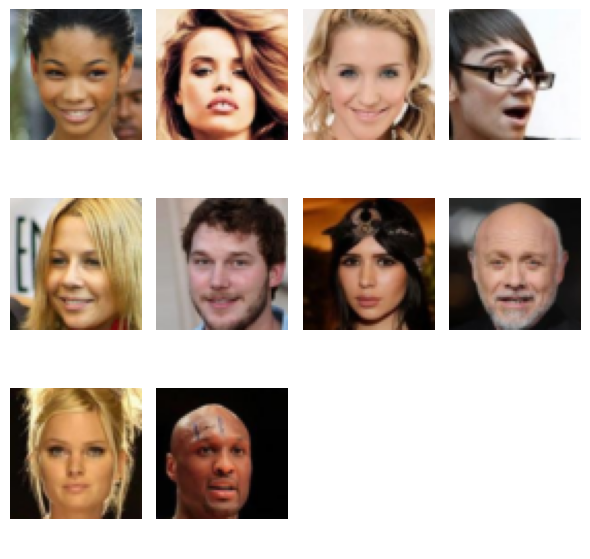

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import torchvision as tv
import matplotlib.pyplot as plt

# Read CSV and keep relevant columns
data = pd.read_csv("./data/list_attr_celeba.csv")
columns_to_keep = [
    'image_id', 'Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Bald', 
    'Eyeglasses', 'No_Beard', 'Wearing_Hat', 'Smiling', 'Male', 'Young'
]
data = data.replace(-1, 0)
data = data[columns_to_keep]

# sample_no = torch.randint(0,20000,(10,))
sample_no = [6577, 1129, 6539, 12993, 19284, 7499, 5899, 8547, 13342, 728]
print(sample_no)

image_data = data.iloc[sample_no]
attribs = torch.tensor(image_data.iloc[:, 1:].values.astype(np.float32))
image_ids = image_data['image_id']

# Build full paths for images
base_paths = [os.path.join('./data/img_align_celeba/img_align_celeba', path) for path in image_ids]
print(base_paths)

# Read and process images
images = []
for path in base_paths:
    # Fixed bug: use 'path' instead of undefined 'base_path'
    img = tv.io.read_image(path)
    img = transforms.v2.functional.resized_crop(
        img, top=40, left=15, height=148, width=148, size=(64, 64), 
        interpolation=transforms.InterpolationMode.BILINEAR, antialias=True
    ) / 255.
    images.append(img)

# Determine grid size (using 4 columns as an example)
n_images = len(images)
cols = 4
rows = (n_images + cols - 1) // cols  # ceil division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
axes = axes.flatten()

# Plot each image
for i, img in enumerate(images):
    # Convert from tensor (C, H, W) to (H, W, C) for displaying
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_183488/11001986.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load('./actor_critiq_models_no_id/actor_model_2.pth'))


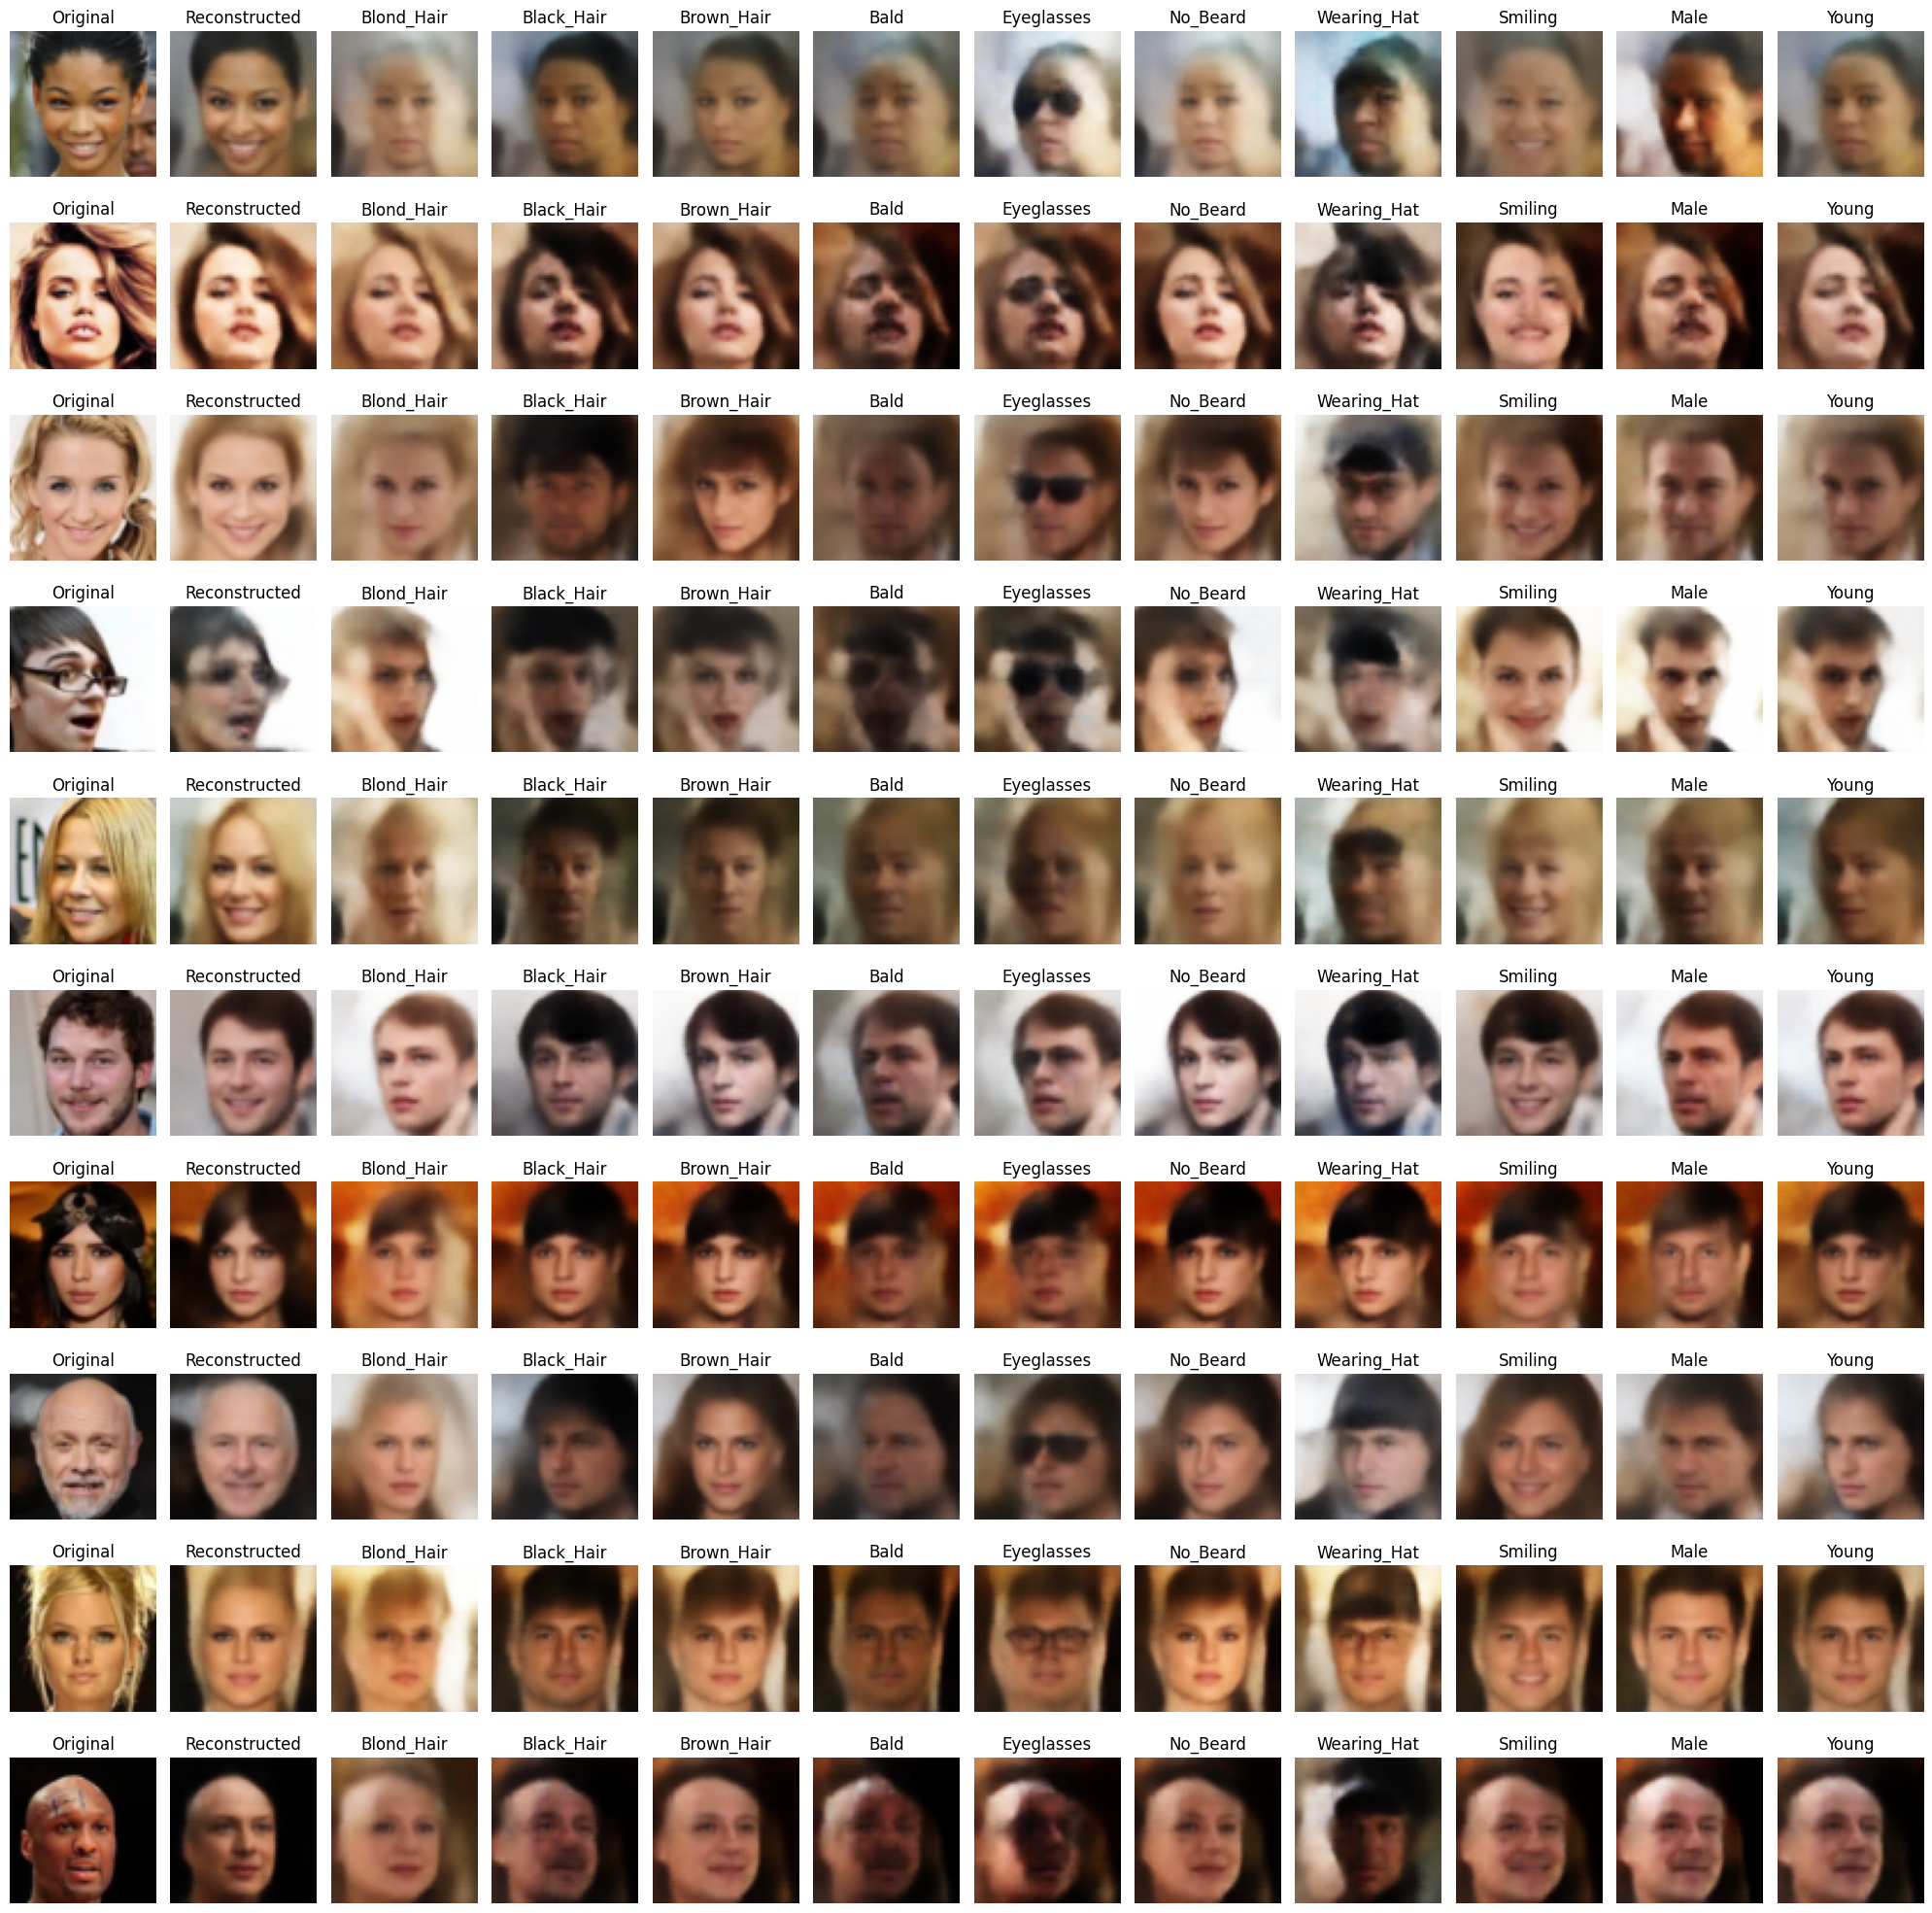

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

actor.load_state_dict(torch.load('./actor_critiq_models_no_id/actor_model_3.pth'))

attributes_tensors = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
]

columns_to_keep = [
    'image_id', 'Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Bald', 
    'Eyeglasses', 'No_Beard', 'Wearing_Hat', 'Smiling', 'Male', 'Young'
]

n_attr = len(attributes_tensors)
n_cols = n_attr + 2 
n_rows = len(images)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))

if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for i, img in enumerate(images):
    
    image_input = img.unsqueeze(0).to(device)  # Shape: [1, C, 64, 64]
    mu, sigma = vaeModel.encoder(image_input)
    latent_vector = vaeModel.reparameterize(mu, sigma)
    
    # --- Column 0: Original image ---
    axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # --- Column 1: Normal reconstruction ---
    # (Assuming latent_vector corresponds to the current image)
    normal_output = vaeModel.decoder(latent_vector)
    axes[i, 1].imshow(normal_output.squeeze().detach().cpu().permute(1, 2, 0))
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")
    
    # --- Columns 2 onward: Attribute-conditioned modifications ---
    for j, (attr_vector, attr_name) in enumerate(zip(attributes_tensors, columns_to_keep[1:])):
        # Convert attribute vector to a tensor, add batch dimension, and send to device
        attr_tensor = torch.tensor(attr_vector, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Generate a new latent vector conditioned on the attribute tensor
        new_latent = actor(latent_vector, attr_tensor)
        
        # Decode the new latent vector to produce an image
        output_image = vaeModel.decoder(new_latent)
        
        # Display the image in the appropriate subplot
        axes[i, j + 2].imshow(output_image.squeeze().detach().cpu().permute(1, 2, 0))
        axes[i, j + 2].set_title(attr_name)
        axes[i, j + 2].axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_179649/1508708490.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load('./actor_critiq_models/actor_model_1.pth'))


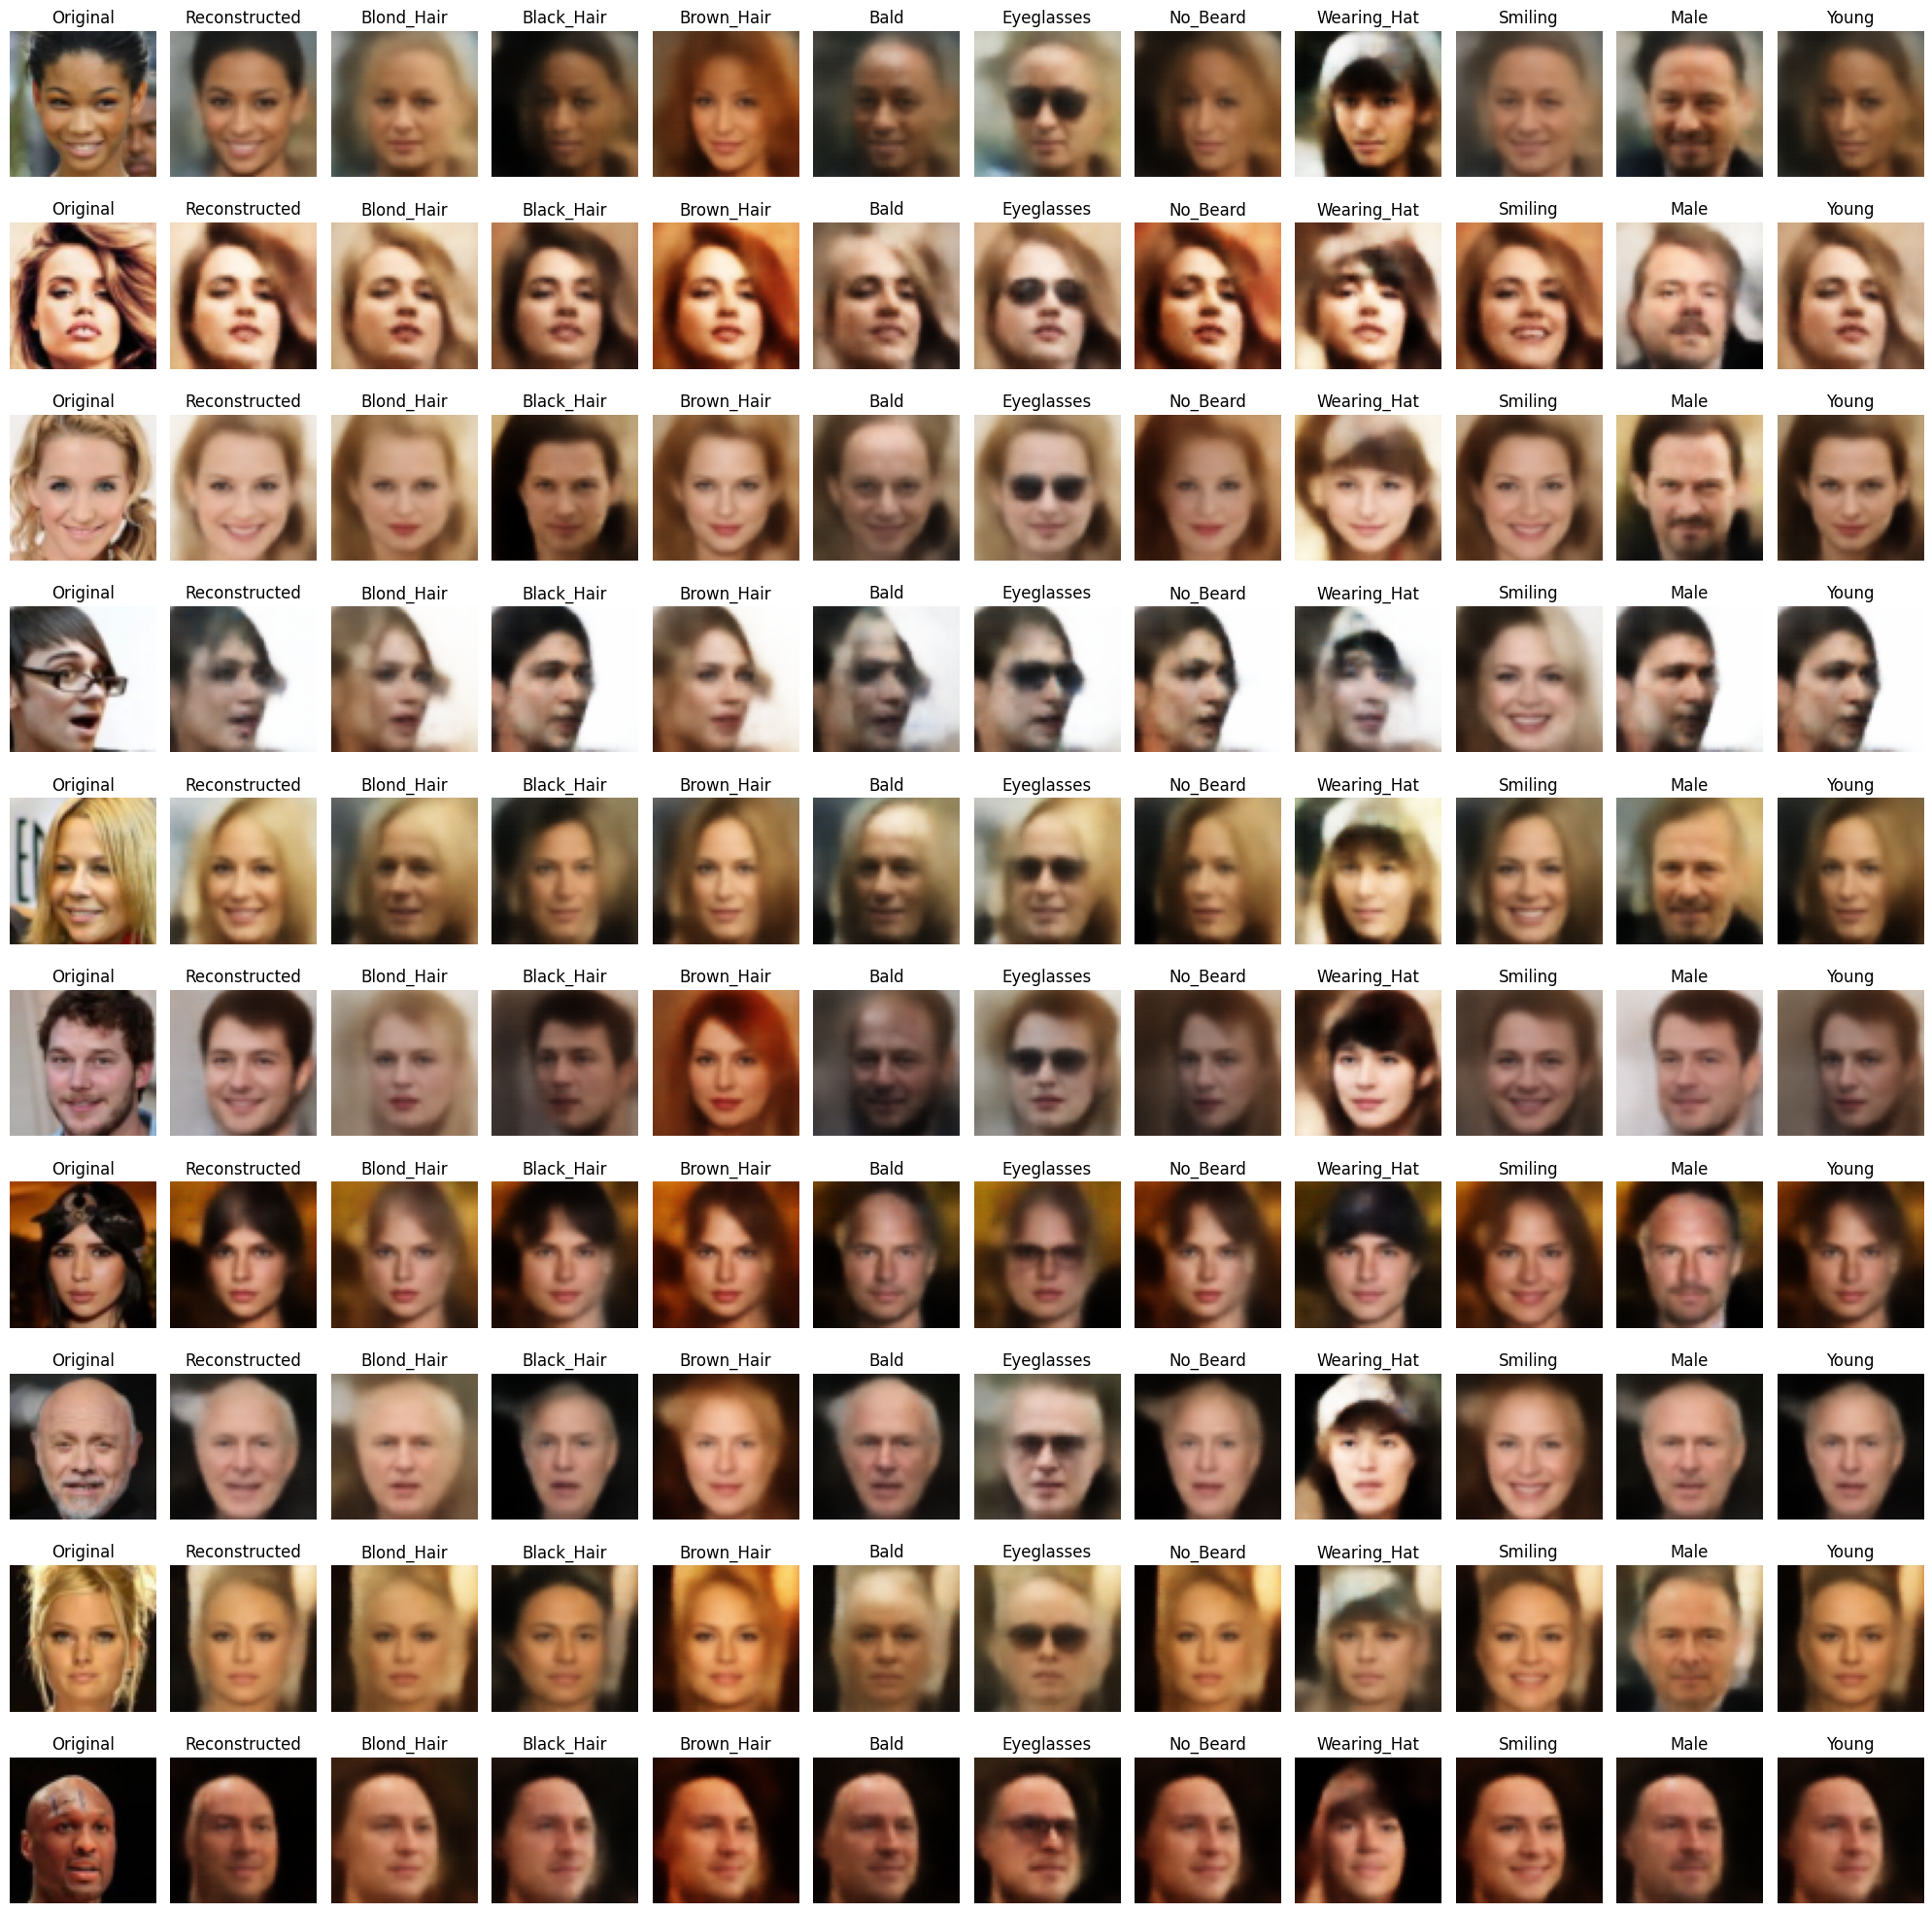

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt

actor.load_state_dict(torch.load('./actor_critiq_models/actor_model_1.pth'))
# model 1

attributes_tensors = [
    [1.3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1.3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1.3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1.3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1.3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1.3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1.3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1.3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1.3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3],
]

columns_to_keep = [
    'image_id', 'Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Bald', 
    'Eyeglasses', 'No_Beard', 'Wearing_Hat', 'Smiling', 'Male', 'Young'
]

n_attr = len(attributes_tensors)
n_cols = n_attr + 2 
n_rows = len(images)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))

if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for i, img in enumerate(images):
    
    image_input = img.unsqueeze(0).to(device)  # Shape: [1, C, 64, 64]
    mu, sigma = vaeModel.encoder(image_input)
    latent_vector = vaeModel.reparameterize(mu, sigma)
    
    # --- Column 0: Original image ---
    axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # --- Column 1: Normal reconstruction ---
    # (Assuming latent_vector corresponds to the current image)
    normal_output = vaeModel.decoder(latent_vector)
    axes[i, 1].imshow(normal_output.squeeze().detach().cpu().permute(1, 2, 0))
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")
    
    # --- Columns 2 onward: Attribute-conditioned modifications ---
    for j, (attr_vector, attr_name) in enumerate(zip(attributes_tensors, columns_to_keep[1:])):
        # Convert attribute vector to a tensor, add batch dimension, and send to device
        attr_tensor = torch.tensor(attr_vector, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Generate a new latent vector conditioned on the attribute tensor
        new_latent = actor(latent_vector, attr_tensor)
        
        # Decode the new latent vector to produce an image
        output_image = vaeModel.decoder(new_latent)
        
        # Display the image in the appropriate subplot
        axes[i, j + 2].imshow(output_image.squeeze().detach().cpu().permute(1, 2, 0))
        axes[i, j + 2].set_title(attr_name)
        axes[i, j + 2].axis("off")

plt.tight_layout()
plt.show()
